In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn  as sns
import pickle
from sklearn import preprocessing

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification

# Models
import statsmodels.api as sm2
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK


# Other imports

from imblearn.over_sampling import SMOTENC


# 1. Pre-procesamiento datos

In [9]:
def getGroups():
    featgroups={"Paciente":['edad_','sexo_','uni_med_'],"Social":['trab_salud','ocupacion_','estrato']
           ,"Salud":['tos','fiebre','odinofagia','dif_res','adinamia','vac_ei','dos_ei','asma','epoc','diabetes','vih','enf_card','cancer','desnutricion','obesidad','ins_renal','otr_medinm','fumador','tuberculos','hallaz_rad','der_ple','der_per','miocarditi','septicemia','falla_resp','rinorrea','conjuntivi','cefalea','diarrea']
           ,"Atención":['NOMBRE EPS','pac_hos_','uso_antib','uso_antiv','tip_ss_','cod_ase_','tip_cas_']
           ,"Grupos":['gp_discapa','gp_desplaz','gp_migrant','gp_carcela','gp_gestan','sem_ges','gp_indigen','gp_pobicbf','gp_mad_com','gp_desmovi','gp_psiquia','gp_vic_vio','gp_otros']
           ,"Fechas":['ini_sin_','fec_con_','fec_hos_','fec_def_','fec_antiv','fec_inguci']
           ,"Output":['Muerto']
}
    return featgroups

def getClaseOcupacion(xs):
    dict_clases={0:'FUERZA PÚBLICA'
                 ,1: 'MIEMBROS DEL PODER EJECUTIVO, DE LOS CUERPOS LEGISLATIVOS Y PERSONAL DIRECTIVO DE LA ADMINISTRACIÓN PÚBLICA Y DE EMPRESAS'
                 ,2:'PROFESIONALES UNIVERSITARIOS, CIENTÍFICOS E INTELECTUALES'
                 ,3: 'TÉCNICOS, POSTSECUNDARIOS NO UNIVERSITARIOS Y ASISTENTES'
                 ,4: 'EMPLEADOS DE OFICINA'
                 ,5: 'TRABAJADORES DE LOS SERVICIOS Y VENDEDORES'
                 ,6: 'AGRICULTORES, TRABAJADORES Y OBREROS AGROPECUARIOS, FORESTALES Y PESQUEROS'
                 ,7: 'OFICIALES, OPERARIOS, ARTESANOS Y TRABAJADORES DE LA INDUSTRIA MANUFACTURERA, DE LA CONSTRUCCIÓN Y DE LA MINERÍA'
                 ,8: 'OPERADORES DE INSTALACIONES, DE MÁQUINAS Y ENSAMBLADORES'
                 ,9: 'TRABAJADORES NO CALIFICADOS'}

    return dict_clases[xs//1000]

def limpiarTodos(data,featgroups,dropColumnsSyC=['vac_ei','dos_ei'],dropSintomasSyC=['der_ple','der_per','falla_resp','septicemia','miocarditi','rinorrea','conjuntivi','cefalea','diarrea'],useAtencion=False,useFechas=False,useGrupos=False,useSocial=False,encode=None,fillEstrato=False,estandarizar=None,scalerFit='None'):
    import pickle
    from sklearn import preprocessing
    SyC=['tos','fiebre','odinofagia','dif_res','adinamia','vac_ei','dos_ei','asma','epoc','diabetes','vih','enf_card','cancer','desnutricion','obesidad','ins_renal','otr_medinm','fumador','tuberculos','hallaz_rad','der_ple','der_per','miocarditi','septicemia','falla_resp','rinorrea','conjuntivi','cefalea','diarrea']
    
    datos=data.copy()
    datos.dos_ei=datos.dos_ei.fillna(2)
    datos.vac_ei=datos.vac_ei.fillna(2)
    datos.hallaz_rad=datos.hallaz_rad.fillna(4) # Significa que no se aplicó radiografía
    
    if dropColumnsSyC:
        datos=datos.drop(dropColumnsSyC, axis=1)
        
        for elemento in dropColumnsSyC:
            SyC.remove(elemento)
        
    if dropSintomasSyC:
        datos=datos.dropna(subset=dropSintomasSyC)
    else:
        
        datos.der_ple=datos.der_ple.fillna(3) # 3 desconocido
        datos.der_per=datos.der_per.fillna(3) # 3 desconocido
        datos.miocarditi=datos.miocarditi.fillna(3) # 3 desconocido
        datos.septicemia=datos.septicemia.fillna(3) # 3 desconocido
        datos.falla_resp=datos.falla_resp.fillna(3) # 3 desconocido
        datos.rinorrea=datos.rinorrea.fillna(3)# 3 desconocido
        datos.conjuntivi=datos.conjuntivi.fillna(3) # 3 desconocido
        datos.cefalea=datos.cefalea.fillna(3) # 3 desconocido
        datos.diarrea=datos.diarrea.fillna(3) # 3 desconocido

    for columna in SyC:
        datos[columna]=datos[columna].astype(int)

    if useAtencion==False:
        datos=datos.drop(featgroups['Atención'],axis=1)
    if useFechas==False:
        datos=datos.drop(featgroups['Fechas'],axis=1)
    if useGrupos==False:
        datos=datos.drop(featgroups['Grupos'],axis=1)
    if useSocial==False:
        datos=datos.drop(featgroups['Social'],axis=1)
    elif fillEstrato:
        datos.estrato=datos.estrato.fillna(round(datos.estrato.mean(),0))
    
    datos.sexo_=datos.sexo_.apply(lambda xs: 1 if xs=='M' else -1)
    
    def mapEdad(xs):
        
        if xs[1]==1:
            return xs[0]*12*30
        elif xs[1]==2:
            return xs[0]*30
        else:
            return xs[0]
    
    datos['edadDias']=datos[['edad_','uni_med_']].apply(lambda xs:mapEdad(xs),axis=1)
    datos=datos.drop(['edad_','uni_med_','unidedad'],axis=1)
    
        
    datos=datos.dropna().reset_index().drop('index',axis=1)
    
    if not estandarizar is None:
        
        if scalerFit=='None':
            scaler = preprocessing.StandardScaler()
            print('Inicializando scaler')
        else:
            scaler= pickle.load(open( "scalerEdad.p", "rb" ) )
            print('Importando scaler')
        
        
        datos1=datos[[elemento for elemento in datos.columns if not elemento in estandarizar]]
        datos2=datos[estandarizar]


        
        datos1=datos1.reset_index()
        try:
            datos1=datos1.drop('index',axis=1)
        except:
            pass

        datos2=datos2.reset_index()
        try:
            datos2=datos2.drop('index',axis=1)
        except:
            pass

        print(datos1.columns)
        
        if scalerFit=='None':
            print('Ajustando y transformando')
            datos2=scaler.fit_transform(datos2)
            print('scaler -- mean:{}, var: {}'.format(scaler.mean_,scaler.var_))
        else:
            print('Tranformando')
            datos2=scaler.transform(datos2)
            print('scaler -- mean:{}, var: {}'.format(scaler.mean_,scaler.var_))
        
        #Guardar scaler
        if scalerFit =='None':
            print('Guardando')
            pickle.dump( scaler, open( "scalerEdad.p", "wb" ) )
        
        datos2=pd.DataFrame(datos2,columns=estandarizar)
        datos=pd.concat([datos1,datos2],axis=1)

    datos['ocupacion_Cat']=datos['ocupacion_'].apply(lambda xs: getClaseOcupacion(xs))

    datos=datos.drop('ocupacion_',axis=1)
    datos=datos.drop('con_fin_',axis=1)

    return datos

def readIRAFile(file,sheet='CORONAVIRUS BUCARAMANGA',filtrarDescesos=True):
    
    data=pd.read_excel('_IRA POR VIRUS NUEVO BUCA 200102020.xlsx',sheet_name="Coronavirus Bucaramanga")

    
    
    if filtrarDescesos==True:
        datosFiltrados=data.copy()
        datosFiltrados=datosFiltrados[datosFiltrados.ajuste_==3]
        #{3:'In UCI', 5:'Death', 1:'In hospital', 4:'recovered', 2:'At home', 6:'No COVID Death' }

        datosFiltrados=datosFiltrados[datosFiltrados.serv_hosp!=3]
        datosFiltrados=datosFiltrados[datosFiltrados.serv_hosp!=1]
        datosFiltrados=datosFiltrados[datosFiltrados.serv_hosp!=2]
        datosFiltrados=datosFiltrados[datosFiltrados.serv_hosp!=6]
        datosFiltrados.loc[datosFiltrados.serv_hosp==5,'Muerto']=1
        datosFiltrados.loc[datosFiltrados.serv_hosp==4,'Muerto']=0
        datosFiltrados=datosFiltrados[['edad_','sexo_','uni_med_','unidedad','trab_salud','ocupacion_','estrato','tos','fiebre','odinofagia','dif_res','adinamia','vac_ei','dos_ei','asma','epoc','diabetes','vih','enf_card','cancer','desnutricion','obesidad','ins_renal','otr_medinm','fumador','tuberculos','hallaz_rad','uso_antiv','der_ple','der_per','miocarditi','septicemia','falla_resp','rinorrea','conjuntivi','cefalea','diarrea','NOMBRE EPS','pac_hos_','uso_antib','tip_ss_','cod_ase_','tip_cas_','gp_discapa','gp_desplaz','gp_migrant','gp_carcela','gp_gestan','sem_ges','gp_indigen','gp_pobicbf','gp_mad_com','gp_desmovi','gp_psiquia','gp_vic_vio','gp_otros','ini_sin_','fec_con_','fec_hos_','fec_def_','fec_antiv','fec_inguci','con_fin_','Muerto']]
        
        data=datosFiltrados
        
        return data
    
def encodeData(datos,fitted=False):
    
    cats=["sexo_","trab_salud","estrato","tos","fiebre","odinofagia","dif_res"
                                          ,"adinamia","asma","epoc","diabetes","vih","enf_card","cancer","desnutricion",
                                          "obesidad","ins_renal","otr_medinm","fumador","tuberculos","miocarditi","hallaz_rad",'der_ple', 'der_per', 'septicemia', 'falla_resp',
       'rinorrea', 'conjuntivi', 'cefalea', 'diarrea','ocupacion_Cat']
    
    from sklearn.preprocessing import OneHotEncoder


    splitA=datos[cats]
    splitB=datos[[columna for columna in datos.columns if not columna in cats]]

    

    if fitted==False:
        print("Ajustando")
        enc=OneHotEncoder(handle_unknown='ignore')
        enc.fit(splitA)
        pickle.dump( enc, open( "encoderCats.p", "wb" ) )
        
        
    elif fitted==True:
        print("Importando")
        enc= pickle.load(open( "encoderCats.p", "rb" ) )
        
    else:
        raise "Envíe algo >:v"
        
        
    print("Transformando")
    enc.transform(splitA).toarray().shape

    fittedencodedData=pd.DataFrame(enc.transform(splitA).toarray().T,list(enc.get_feature_names())).T 

    assert fittedencodedData.shape[1]==84, "El output no es correcto"
    
    fittedencodedData=pd.concat([splitB,fittedencodedData],axis=1)
    
    return fittedencodedData

### Data Base

In [10]:
### load the database and apply the cleanup functions to select the variables

datos=readIRAFile('_IRA POR VIRUS NUEVO BUCA 200102020.xlsx',sheet='Coronavirus Bucaramanga')

In [11]:
### Select feature groups

featgroups=getGroups()
datosB=limpiarTodos(datos,featgroups,useSocial=True,fillEstrato=True,estandarizar=['edadDias'],scalerFit='None')
Datos=encodeData(datosB)

Inicializando scaler
Index(['sexo_', 'trab_salud', 'ocupacion_', 'estrato', 'tos', 'fiebre',
       'odinofagia', 'dif_res', 'adinamia', 'asma', 'epoc', 'diabetes', 'vih',
       'enf_card', 'cancer', 'desnutricion', 'obesidad', 'ins_renal',
       'otr_medinm', 'fumador', 'tuberculos', 'hallaz_rad', 'der_ple',
       'der_per', 'miocarditi', 'septicemia', 'falla_resp', 'rinorrea',
       'conjuntivi', 'cefalea', 'diarrea', 'con_fin_', 'Muerto'],
      dtype='object')
Ajustando y transformando
scaler -- mean:[15386.79901609], var: [47352096.65172394]
Guardando
Ajustando
Transformando


### Oversample

In [12]:
### Smote and Split

### Select the X features and y variable

X=Datos[[columna for columna in Datos if not columna =='Muerto']]
y=Datos["Muerto"]



In [13]:
### Train and test 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)


In [14]:
### Apply oversample in train set, use Smote librery


oversample = SMOTENC(categorical_features=[0,1],random_state=42)

X_train,y_train= oversample.fit_resample(X_train,y_train)


### Count data and go to next step

from collections import Counter
target = y_train
counter = Counter(target)

for k,v in counter.items():
    per = v / len(target) * 100
    print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))
from collections import Counter

target = y


counter = Counter(target)

for k,v in counter.items():
    per = v / len(target) * 100
    print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))


Class=0, Count=7463, Percentage=50.000%
Class=1, Count=7463, Percentage=50.000%
Class=0, Count=9330, Percentage=95.624%
Class=1, Count=427, Percentage=4.376%


# Modelos

### Decision Tree

In [15]:
DT = DecisionTreeClassifier(random_state=42, class_weight="balanced")
max_features = range(1,50)
criterion = ['gini','entropy']
max_depth = range(1,50)


grid = dict(max_features=max_features,criterion=criterion,max_depth=max_depth)
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=DT, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1_macro',verbose=1)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 5 folds for each of 4802 candidates, totalling 24010 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 440 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 1440 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 2840 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 4640 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done 6516 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 7166 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 7936 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 9636 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 11536 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 13636 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 15936 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 18436 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 21136 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 24010 out 

Best: 0.966141 using {'criterion': 'entropy', 'max_depth': 38, 'max_features': 10}


Accuracy of DT cross-validation: 0.9661686418248869
Cross-validation precision 0.9670297407659099
Cross-validation f1 0.9661413809546074
Cross-validation  Recall 0.9667752460544202
              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96      1867
         1.0       0.30      0.40      0.34        85

    accuracy                           0.93      1952
   macro avg       0.64      0.68      0.65      1952
weighted avg       0.94      0.93      0.94      1952



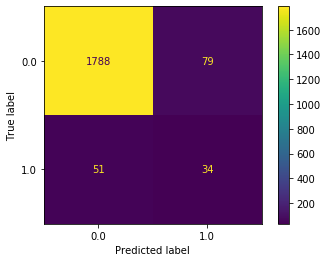

In [16]:
BestDT=grid_result.best_estimator_
BestDT_pred=BestDT.predict(X_test)
plot_confusion_matrix(BestDT, X_test, y_test)
print('Accuracy of DT cross-validation:',
    cross_val_score(BestDT,X_train, y_train, cv=cv).mean())
print('Cross-validation precision', cross_val_score(BestDT, X_train, y_train, cv=cv, scoring = 'precision_macro').mean())
print('Cross-validation f1', cross_val_score(BestDT, X_train, y_train, cv=cv, scoring = 'f1_macro').mean())
print('Cross-validation  Recall', cross_val_score(BestDT, X_train, y_train, cv=cv, scoring = 'recall').mean())
print(classification_report(y_test,BestDT_pred))

### Random Forest

In [22]:
# define models and parameters
RF= RandomForestClassifier(random_state=42)
max_features = range(1,20)
max_estimators=range(1,20)
criterion = ['gini', 'entropy']
max_depth = range(1,20)
cv = StratifiedKFold(n_splits=5)
grid = dict(max_features=max_features,criterion=criterion,max_depth=max_depth, n_estimators=max_estimators)
grid_search = GridSearchCV(estimator=RF, param_grid=grid, n_jobs=-1, cv=cv, verbose=1,scoring="f1_macro")
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 5 folds for each of 13718 candidates, totalling 68590 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 2428 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 3528 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 4828 tasks      | elapsed:   55.5s
[Parallel(n_jobs=-1)]: Done 6328 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 8028 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 9928 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 12028 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 14328 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 16828 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 19528 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 22026 tasks 

Best: 0.977080 using {'criterion': 'entropy', 'max_depth': 19, 'max_features': 11, 'n_estimators': 19}


Accuracy of RF classifier on test set: 0.95
Accuracy of RF cross-validation: 0.9770887031720334
Cross-validation Precision  0.977566543988041
Cross-validation f1 0.9770795586450538
Cross-validation  Recall 0.9807089922767375
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      1867
         1.0       0.48      0.49      0.49        85

    accuracy                           0.95      1952
   macro avg       0.73      0.74      0.73      1952
weighted avg       0.96      0.95      0.96      1952



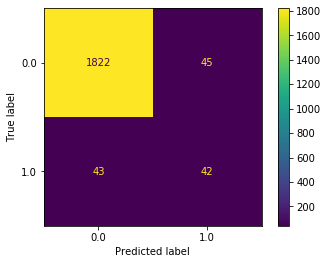

In [23]:
BestRF=grid_search.best_estimator_
BestRF_pred=BestRF.predict(X_test)
plot_confusion_matrix(BestRF, X_test, y_test)
print('Accuracy of RF classifier on test set: {:.2f}'
     .format(BestRF.score(X_test, y_test)))
print('Accuracy of RF cross-validation:',
    cross_val_score(BestRF,X_train, y_train, cv=cv).mean())
print('Cross-validation Precision ', cross_val_score(BestRF, X_train, y_train, cv=cv, scoring = 'precision_macro').mean())
print('Cross-validation f1', cross_val_score(BestRF, X_train, y_train, cv=cv, scoring = 'f1_macro').mean())
print('Cross-validation  Recall', cross_val_score(BestRF, X_train, y_train, cv=cv, scoring = 'recall').mean())
print(classification_report(y_test,BestRF_pred) )

### Gradient Boosting

In [32]:
cv = StratifiedKFold(n_splits=5)
def hyperopt_train_test(params):
    clf = GradientBoostingClassifier(**params, random_state=42)
    return cross_val_score(clf, X_train, y_train, cv=cv, scoring="f1_macro").mean()
space4rf = {
    'max_depth': hp.choice('max_depth', range(1,30)),
    'max_features': hp.choice('max_features', range(1,50)),
    'n_estimators': hp.choice('n_estimators', range(1,25)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1))}
best = 0
def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}
trials = Trials()
best = fmin(f, space4rf, algo=tpe.suggest, max_evals=10, trials=trials)
print('best:')
print(best)

100%|██████████| 10/10 [00:53<00:00,  5.36s/trial, best loss: -0.9770760198999913]
best:
{'learning_rate': 0.04230587639682821, 'max_depth': 19, 'max_features': 9, 'n_estimators': 13}


Accuracy of GB classifier on test set: 0.95
Accuracy of GB cross-validation: 0.9790989778093415
Cross-validation precission 0.9797811306170914
Cross-validation (f1) 0.9790989778093415
Cross-validation  Recall 0.9778960439153943
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97      1867
         1.0       0.43      0.40      0.41        85

    accuracy                           0.95      1952
   macro avg       0.70      0.69      0.69      1952
weighted avg       0.95      0.95      0.95      1952



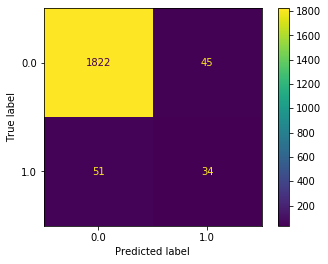

In [30]:
### In this part use the Hyper search and put manual the selection

GB = GradientBoostingClassifier(n_estimators=13, learning_rate=0.19, max_features=4, max_depth=28, random_state=42)
GB.fit(X_train, y_train)
GB_pred=GB.predict(X_test)
plot_confusion_matrix(GB, X_test, y_test)
print('Accuracy of GB classifier on test set: {:.2f}'
     .format(GB.score(X_test, y_test)))
print('Accuracy of GB cross-validation:',
    cross_val_score(GB,X_train, y_train, cv=cv).mean())
print('Cross-validation precission', cross_val_score(GB, X_train, y_train, cv=5, scoring = 'precision_macro').mean())
print('Cross-validation (f1)', cross_val_score(GB, X_train, y_train, cv=5, scoring = 'f1_micro').mean())
print('Cross-validation  Recall', cross_val_score(GB, X_train, y_train, cv=cv, scoring = 'recall').mean())
print(classification_report(y_test,GB_pred))

### VOTING

In [34]:
### Use VotingClassifier for improve the results of Forests

from sklearn.ensemble import VotingClassifier
eclf = VotingClassifier(estimators=[('GB', GB),("RF",BestRF),("DT",BestDT)],voting='soft')
for clf, label in zip([BestDT,BestRF,GB,eclf], ['Decision Tree',"Random Forest","Gradient Boosting",'Ensemble']):
    scores = cross_val_score(clf, X_train, y_train, scoring='f1_macro', cv=cv)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.97 (+/- 0.02) [Decision Tree]
Accuracy: 0.98 (+/- 0.01) [Random Forest]
Accuracy: 0.98 (+/- 0.02) [Gradient Boosting]
Accuracy: 0.98 (+/- 0.02) [Ensemble]


              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      1867
         1.0       0.39      0.39      0.39        85

    accuracy                           0.95      1952
   macro avg       0.68      0.68      0.68      1952
weighted avg       0.95      0.95      0.95      1952

Accuracy of ECLF classifier on test set: 0.95
Accuracy of ECLF cross-validation: 0.9762851767208446
Cross-validation Precission 0.9770878361407934
Cross-validation  f1 0.9762646236617266
Cross-validation  Recall 0.9768242863479077


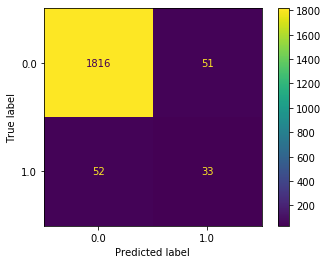

In [35]:
eclf.fit(X_train,y_train)
eclf_pred=eclf.predict(X_test)
plot_confusion_matrix(eclf, X_test, y_test)
class_report=classification_report(y_test,eclf_pred)
print(class_report)
print('Accuracy of ECLF classifier on test set: {:.2f}'
     .format(eclf.score(X_test, y_test)))
print('Accuracy of ECLF cross-validation:',
    cross_val_score(eclf,X_train, y_train, cv=cv).mean())
print('Cross-validation Precission', cross_val_score(eclf, X_train, y_train, cv=cv, scoring = 'precision_macro').mean())
print('Cross-validation  f1', cross_val_score(eclf, X_train, y_train, cv=cv, scoring = 'f1_macro').mean())
print('Cross-validation  Recall', cross_val_score(eclf, X_train, y_train, cv=cv, scoring = 'recall').mean())

### KNN

In [32]:
n_neighbors = list(range(1,30))
p=[1,2]
cv = StratifiedKFold(n_splits=5)
#Convert to dictionary
hyperparameters = dict(n_neighbors=n_neighbors, p=p)
#Create new KNN object
knn = KNeighborsClassifier()
#Use GridSearch
knn_search = GridSearchCV(knn, hyperparameters, cv=cv, scoring="f1_macro")
knn_result= knn_search.fit(X_train,y_train)
# summarize results
print("Best: %f using %s" % (knn_result.best_score_, knn_result.best_params_))
CV_Result = cross_val_score(knn_result, X_train, y_train, cv=cv, scoring="f1_macro")
print(); print(CV_Result)
print(); print(CV_Result.mean())
print(); print(CV_Result.std())

Best: 0.973468 using {'n_neighbors': 1, 'p': 1}

[0.96617518 0.97889287 0.9809041  0.96817215 0.97319521]

0.9734679020650072

0.005762474622745834


<bound method BaseEstimator.get_params of KNeighborsClassifier(n_neighbors=1, p=1)>
Accuracy of KNN classifier on test set: 0.94
Accuracy of KNN cross-validation: 0.9734696029825395
Cross-validation Precission 0.9735917028507052
Cross-validation  f1 0.9734679020650072
Cross-validation  Recall 0.9808404367836319
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      1867
         1.0       0.37      0.45      0.40        85

    accuracy                           0.94      1952
   macro avg       0.67      0.71      0.69      1952
weighted avg       0.95      0.94      0.95      1952



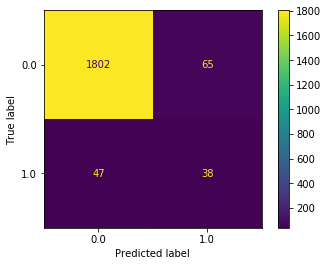

In [37]:
BestKnn=knn_search.best_estimator_
print(BestKnn.get_params)
BestKnn_pred=BestKnn.predict(X_test)
plot_confusion_matrix(BestKnn, X_test, y_test)
class_report=classification_report(y_test,BestKnn_pred)


print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(BestKnn.score(X_test, y_test)))
print('Accuracy of KNN cross-validation:',
    cross_val_score(BestKnn,X_train, y_train, cv=cv).mean())
print('Cross-validation Precission', cross_val_score(BestKnn, X_train, y_train, cv=cv, scoring = 'precision_macro').mean())
print('Cross-validation  f1', cross_val_score(BestKnn, X_train, y_train, cv=cv, scoring = 'f1_macro').mean())
print('Cross-validation  Recall', cross_val_score(BestKnn, X_train, y_train, cv=cv, scoring = 'recall').mean())
print(class_report)

### LOGISTIC

In [73]:
# Gid searching key hyperparametres for logistic regression
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
cv = StratifiedKFold(n_splits=5)
# define models and parameters
log = LogisticRegression(multi_class="multinomial", max_iter=1000, random_state=42)
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
log_search = GridSearchCV(estimator=log, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1_macro')
log_result = log_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (log_result.best_score_, log_result.best_params_))
means = log_result.cv_results_['mean_test_score']
stds = log_result.cv_results_['std_test_score']
params = log_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.906395 using {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.906327 (0.005029) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.906260 (0.005139) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
nan (nan) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.906395 (0.005015) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.906395 (0.005015) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
nan (nan) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.906193 (0.005413) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.906193 (0.005413) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
nan (nan) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.905857 (0.005770) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.905857 (0.005770) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
nan (nan) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.904983 (0.006031) with: {'C': 0.01, 'penalty': 'l2', 'solver':

              precision    recall  f1-score   support

         0.0       1.00      0.88      0.94      1867
         1.0       0.26      0.91      0.41        85

    accuracy                           0.88      1952
   macro avg       0.63      0.89      0.67      1952
weighted avg       0.96      0.88      0.91      1952

Accuracy of Log classifier on test set: 0.67
Accuracy of Log cross-validation: 0.9059250297088521
Cross-validation Precission 0.9061291912221264
Cross-validation F1 0.9059250297088521
Cross-validation  Recall 0.9162535981138074


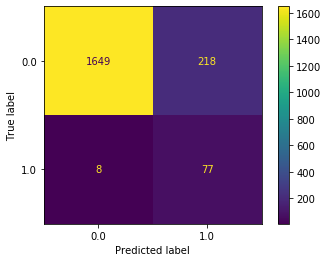

In [74]:
log_pred=log_result.predict(X_test)
plot_confusion_matrix(log_result, X_test, y_test)
class_report=classification_report(y_test,log_pred)
cv = StratifiedKFold(n_splits=5)
print(class_report)
print('Accuracy of Log classifier on test set: {:.2f}'
     .format(log_result.score(X_test, y_test)))
print('Accuracy of Log cross-validation:',
    cross_val_score(log_result,X_train, y_train, cv=cv).mean())
print('Cross-validation Precission', cross_val_score(log_result, X_train, y_train, cv=cv, scoring = 'precision_macro').mean())
print('Cross-validation F1', cross_val_score(log_result, X_train, y_train, cv=cv, scoring = 'f1_macro').mean())
print('Cross-validation  Recall', cross_val_score(log_result, X_train, y_train, cv=cv, scoring = 'recall').mean())

In [92]:
### Coeficientes:
# Best: 0.906395 using {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
log_model= LogisticRegression(penalty="l2",C=10, solver="newton-cg", random_state=42)
log_model=log_model.fit(X_train, y_train)


array([[ 1.75624875e+00, -8.54717277e-01, -2.40421626e-03,
        -3.86944494e-01,  3.86767013e-01,  1.02897037e-01,
         2.07082163e-01,  9.19799818e-01,  3.18478212e-01,
        -4.65166448e-01, -1.08326826e+00,  3.39586835e-01,
        -3.39764316e-01,  2.10308749e-01, -2.10486230e-01,
        -4.55885129e-01,  4.55707648e-01,  9.56150410e-01,
        -9.56327891e-01,  2.31556889e-01, -2.31734371e-01,
         9.31679457e-02, -9.33454270e-02, -8.91879606e-02,
         8.90104793e-02,  6.56202019e-01, -6.56379500e-01,
        -9.03123541e-03,  8.85375408e-03,  1.04167555e-01,
        -1.04345036e-01,  3.36325462e-02, -3.38100276e-02,
         8.95372406e-01, -8.95549888e-01,  4.70998255e-01,
        -4.71175736e-01,  5.89742933e-02, -5.91517746e-02,
        -2.24751918e-01,  2.24574436e-01, -8.84979919e-02,
         8.83205106e-02, -2.94280401e+00,  2.94262653e+00,
        -3.62984838e-01,  3.62807357e-01, -3.62984838e-01,
         8.31710057e-01, -2.35412596e-01,  6.19824284e-0

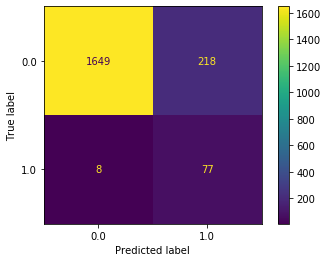

In [94]:
### Print Betas for logistic model

plot_confusion_matrix(log_model, X_test, y_test)
log_model.coef_

Feature: 0, Score: 1.75625
Feature: 1, Score: -0.85472
Feature: 2, Score: -0.00240
Feature: 3, Score: -0.38694
Feature: 4, Score: 0.38677
Feature: 5, Score: 0.10290
Feature: 6, Score: 0.20708
Feature: 7, Score: 0.91980
Feature: 8, Score: 0.31848
Feature: 9, Score: -0.46517
Feature: 10, Score: -1.08327
Feature: 11, Score: 0.33959
Feature: 12, Score: -0.33976
Feature: 13, Score: 0.21031
Feature: 14, Score: -0.21049
Feature: 15, Score: -0.45589
Feature: 16, Score: 0.45571
Feature: 17, Score: 0.95615
Feature: 18, Score: -0.95633
Feature: 19, Score: 0.23156
Feature: 20, Score: -0.23173
Feature: 21, Score: 0.09317
Feature: 22, Score: -0.09335
Feature: 23, Score: -0.08919
Feature: 24, Score: 0.08901
Feature: 25, Score: 0.65620
Feature: 26, Score: -0.65638
Feature: 27, Score: -0.00903
Feature: 28, Score: 0.00885
Feature: 29, Score: 0.10417
Feature: 30, Score: -0.10435
Feature: 31, Score: 0.03363
Feature: 32, Score: -0.03381
Feature: 33, Score: 0.89537
Feature: 34, Score: -0.89555
Feature: 35, 

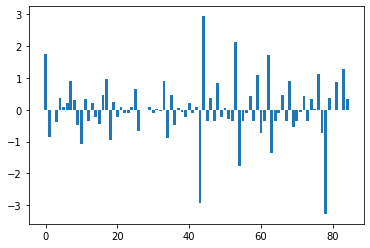

In [98]:
importance = log_model.coef_[0]
# summarize feature importance
for i,v in zip(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

### Create DataFrame

Create a df with probabilities for predict in test set

In [61]:
df=pd.DataFrame(log_result.predict_proba(X_test),columns=['probaVivir','probaMorir'])
df['class']=log_result.predict(X_test)
df

,probaVivir,probaMorir,class
0,0.115255,0.884745,1.0
1,0.985075,0.014925,0.0
2,0.981074,0.018926,0.0
3,0.998803,0.001197,0.0
4,0.272271,0.727729,1.0
...,...,...,...
1947,0.880155,0.119845,0.0
1948,0.994493,0.005507,0.0
1949,0.393176,0.606824,1.0
1950,0.963741,0.036259,0.0


In [63]:
df['trueclass']=y_test.reset_index().drop('index',axis=1)

In [1]:
### Add the True Positive and False Positive

malclasificados=df[df['class']!=df['trueclass']]
bienclasificados=df[df['class']==df['trueclass']]

NameError: name 'df' is not defined

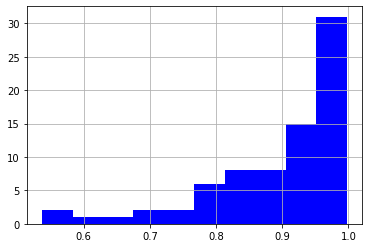

In [69]:
# bienclasificados[bienclasificados['class']==1].probaVivir.hist(color='red')
bienclasificados[bienclasificados['class']==1].probaMorir.hist(color='blue')
# malclasificados[malclasificados['class']==1].probaMorir.hist(color='red')

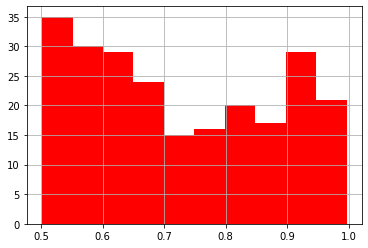

In [70]:
malclasificados[malclasificados['class']==1].probaMorir.hist(color='red')

### Compare with the Best Model for f1 score (Random Forest)

In [24]:
df2=pd.DataFrame(BestRF.predict_proba(X_test),columns=['probaVivir','probaMorir'])
df2['class']=BestRF.predict(X_test)

df2['trueclass']=y_test.reset_index().drop('index',axis=1)

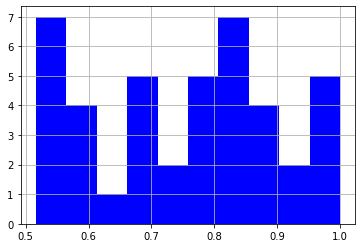

In [27]:
malclasificados=df2[df2['class']!=df2['trueclass']]
bienclasificados=df2[df2['class']==df2['trueclass']]

bienclasificados[bienclasificados['class']==1].probaMorir.hist(color='blue')


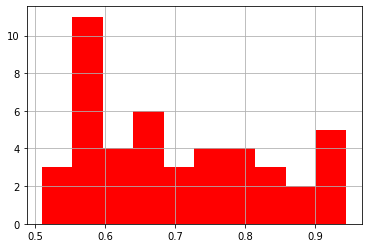

In [26]:
malclasificados[malclasificados['class']==1].probaMorir.hist(color='red')

In [72]:
print(bienclasificados[bienclasificados['class']==1].count())
print(malclasificados[malclasificados['class']==1].count())

probaVivir    76
probaMorir    76
class         76
trueclass     76
dtype: int64
probaVivir    236
probaMorir    236
class         236
trueclass     236
dtype: int64


### Import The best model : Logistic

In [76]:
import joblib

joblib.dump(log_result, 'modelLog.model') 


['modelLog.model']

### SVM

# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}

Grid scores on development set:

0.915 (+/-0.013) for {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
0.938 (+/-0.013) for {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
0.966 (+/-0.022) for {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
0.908 (+/-0.010) for {'C': 1, 'kernel': 'linear'}
0.908 (+/-0.011) for {'C': 10, 'kernel': 'linear'}
0.908 (+/-0.011) for {'C': 100, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97      1867
         1.0       0.40      0.62      0.49        85

    accuracy                           0.94      1952
   macro avg       0.69      0.79      0.73      1952
weighted avg       0.96      0.94      0.95      1952




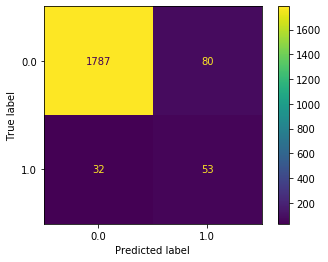

In [41]:
from sklearn.svm import SVC
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': ['auto'],
                     'C': [1, 10, 100]},
                    {'kernel': ['linear'], 'C': [1, 10, 100]}]

scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(#'%s_macro' % score
        SVC(probability=True, random_state=42), tuned_parameters, scoring='%s_macro' % score, cv=5,n_jobs=-1
    )
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    plot_confusion_matrix(clf,X_test, y_test)
    print()

    ### PROBLEMAS CON ZERO DIVISION
    

### Curvas Roc

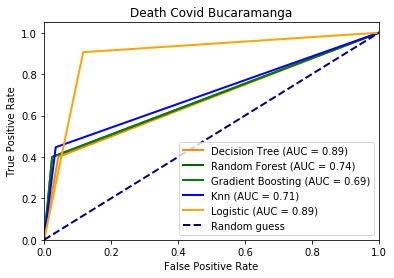

In [46]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
###Roc
roc_dt = roc_curve(y_test,BestDT_pred)
roc_rf = roc_curve(y_test, BestRF_pred)
roc_gb=roc_curve(y_test,GB_pred)
roc_knn=roc_curve(y_test,BestKnn_pred)
roc_log=roc_curve(y_test, log_pred)
###Auc
auc_dt = auc( roc_dt[0], roc_dt[1] )
auc_rf = auc( roc_rf[0], roc_rf[1])
auc_gb=auc(roc_gb[0], roc_gb[1])
auc_knn=auc(roc_knn[0], roc_knn[1])
auc_log=auc(roc_log[0], roc_log[1])

plt.figure()
line_width = 2
plt.plot(roc_dt[0], roc_dt[1], color='darkorange',
         lw=line_width, label=f'Decision Tree (AUC = {auc_log:0.2f})')
plt.plot(roc_rf[0], roc_dt[1], color='darkgreen',
         lw=line_width, label=f'Random Forest (AUC = {auc_rf:0.2f})')
plt.plot(roc_gb[0], roc_gb[1], color='green',
         lw=line_width, label=f'Gradient Boosting (AUC = {auc_gb:0.2f})')
plt.plot(roc_knn[0], roc_knn[1], color='blue',
         lw=line_width, label=f'Knn (AUC = {auc_knn:0.2f})')
plt.plot(roc_log[0], roc_log[1], color='orange',
         lw=line_width, label=f'Logistic (AUC = {auc_log:0.2f})')



plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Death Covid Bucaramanga')
plt.legend(loc='lower right')
plt.show()

# MODELOS CON RECALL

### Decision Tree

In [47]:
DT = DecisionTreeClassifier(random_state=42)
max_features = range(1,20)
criterion = ['gini','entropy']
max_depth = range(1,20)


grid = dict(max_features=max_features,criterion=criterion,max_depth=max_depth)
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=DT, param_grid=grid, n_jobs=-1, cv=cv, scoring='recall',verbose=1)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 5 folds for each of 722 candidates, totalling 3610 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 1480 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 2380 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 3480 tasks      | elapsed:   33.2s


Best: 0.973202 using {'criterion': 'entropy', 'max_depth': 2, 'max_features': 12}


[Parallel(n_jobs=-1)]: Done 3610 out of 3610 | elapsed:   34.6s finished


Accuracy of DT cross-validation: 0.8389375096065279
Cross-validation precision 0.8657794385587241
Cross-validation f1 0.8358720812858763
Cross-validation  Recall 0.9732021102948704
              precision    recall  f1-score   support

         0.0       1.00      0.68      0.81      1867
         1.0       0.12      0.95      0.21        85

    accuracy                           0.69      1952
   macro avg       0.56      0.81      0.51      1952
weighted avg       0.96      0.69      0.78      1952



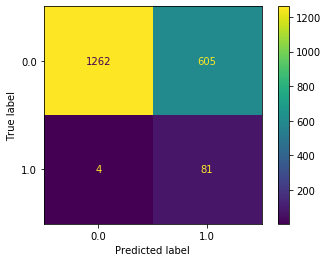

In [48]:
BestDT=grid_result.best_estimator_
BestDT_pred=BestDT.predict(X_test)
plot_confusion_matrix(BestDT, X_test, y_test)
print('Accuracy of DT cross-validation:',
    cross_val_score(BestDT,X_train, y_train, cv=cv).mean())
print('Cross-validation precision', cross_val_score(BestDT, X_train, y_train, cv=cv, scoring = 'precision_macro').mean())
print('Cross-validation f1', cross_val_score(BestDT, X_train, y_train, cv=cv, scoring = 'f1_macro').mean())
print('Cross-validation  Recall', cross_val_score(BestDT, X_train, y_train, cv=cv, scoring = 'recall').mean())
print(classification_report(y_test,BestDT_pred))

### Random Forest

In [49]:
# define models and parameters
RF= RandomForestClassifier(random_state=42)
max_features = range(1,20)
max_estimators=range(1,20)
criterion = ['gini', 'entropy']
max_depth = range(1,20)
cv = StratifiedKFold(n_splits=5)
grid = dict(max_features=max_features,criterion=criterion,max_depth=max_depth, n_estimators=max_estimators)
grid_search = GridSearchCV(estimator=RF, param_grid=grid, n_jobs=-1, cv=cv, verbose=1,scoring="recall")
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 5 folds for each of 13718 candidates, totalling 68590 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 2428 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 3528 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 4828 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 6328 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 8028 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 9928 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 12028 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 14328 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 16828 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 19528 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 22428 tasks 

Best: 0.982317 using {'criterion': 'entropy', 'max_depth': 17, 'max_features': 11, 'n_estimators': 19}


Accuracy of RF classifier on test set: 0.95
Accuracy of RF cross-validation: 0.9748776478956515
Cross-validation Precision  0.9753165618616148
Cross-validation f1 0.9748709486768579
Cross-validation  Recall 0.9823165837357175
              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97      1867
         1.0       0.42      0.56      0.48        85

    accuracy                           0.95      1952
   macro avg       0.70      0.76      0.73      1952
weighted avg       0.96      0.95      0.95      1952



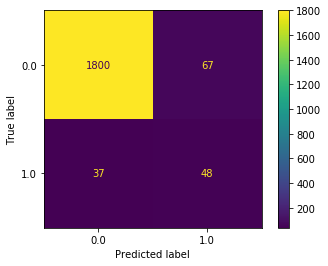

In [50]:
BestRF=grid_search.best_estimator_
BestRF_pred=BestRF.predict(X_test)
plot_confusion_matrix(BestRF, X_test, y_test)
print('Accuracy of RF classifier on test set: {:.2f}'
     .format(BestRF.score(X_test, y_test)))
print('Accuracy of RF cross-validation:',
    cross_val_score(BestRF,X_train, y_train, cv=cv).mean())
print('Cross-validation Precision ', cross_val_score(BestRF, X_train, y_train, cv=cv, scoring = 'precision_macro').mean())
print('Cross-validation f1', cross_val_score(BestRF, X_train, y_train, cv=cv, scoring = 'f1_macro').mean())
print('Cross-validation  Recall', cross_val_score(BestRF, X_train, y_train, cv=cv, scoring = 'recall').mean())
print(classification_report(y_test,BestRF_pred) )

### Gradient Boosting


Pendiente

In [51]:
cv = StratifiedKFold(n_splits=5)
def hyperopt_train_test(params):
    clf = GradientBoostingClassifier(**params, random_state=42)
    return cross_val_score(clf, X_train, y_train, cv=cv, scoring="recall").mean()
space4rf = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', range(1,20)),
    'n_estimators': hp.choice('n_estimators', range(1,25)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1))}
best = 0
def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}
trials = Trials()
best = fmin(f, space4rf, algo=tpe.suggest, max_evals=10, trials=trials)
print('best:')
print(best)

100%|██████████| 10/10 [00:14<00:00,  1.46s/trial, best loss: -0.9745469025245607]
best:
{'learning_rate': 0.7387897690657034, 'max_depth': 5, 'max_features': 10, 'n_estimators': 20}


Accuracy of GB classifier on test set: 0.95
Accuracy of GB cross-validation: 0.976954856892186
Cross-validation precission 0.9774540007991387
Cross-validation (f1) 0.9769450243523012
Cross-validation  Recall 0.9807091718457357
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98      1867
         1.0       0.46      0.51      0.48        85

    accuracy                           0.95      1952
   macro avg       0.72      0.74      0.73      1952
weighted avg       0.95      0.95      0.95      1952



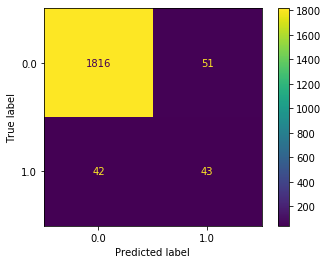

In [52]:
GB = GradientBoostingClassifier(n_estimators=21, learning_rate=0.075, max_features=9, max_depth=17, random_state=42)
GB.fit(X_train, y_train)
GB_pred=GB.predict(X_test)
plot_confusion_matrix(GB, X_test, y_test)
print('Accuracy of GB classifier on test set: {:.2f}'
     .format(GB.score(X_test, y_test)))
print('Accuracy of GB cross-validation:',
    cross_val_score(GB,X_train, y_train, cv=cv).mean())
print('Cross-validation precission', cross_val_score(GB, X_train, y_train, cv=5, scoring = 'precision_macro').mean())
print('Cross-validation (f1)', cross_val_score(GB, X_train, y_train, cv=5, scoring = 'f1_macro').mean())
print('Cross-validation  Recall', cross_val_score(GB, X_train, y_train, cv=cv, scoring = 'recall').mean())
print(classification_report(y_test,GB_pred))

### Ensamble Forest

In [53]:
from sklearn.ensemble import VotingClassifier
eclf = VotingClassifier(estimators=[('GB', GB),("RF",BestRF),("DT",BestDT)],voting='soft')
for clf, label in zip([BestDT,BestRF,GB,eclf], ['Decision Tree',"Random Forest","Gradient Boosting",'Ensemble']):
    scores = cross_val_score(clf, X_train, y_train, scoring='f1_macro', cv=cv)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.84 (+/- 0.01) [Decision Tree]
Accuracy: 0.97 (+/- 0.01) [Random Forest]
Accuracy: 0.98 (+/- 0.01) [Gradient Boosting]
Accuracy: 0.97 (+/- 0.01) [Ensemble]


              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97      1867
         1.0       0.40      0.66      0.50        85

    accuracy                           0.94      1952
   macro avg       0.69      0.81      0.73      1952
weighted avg       0.96      0.94      0.95      1952

Accuracy of ECLF classifier on test set: 0.94
Accuracy of ECLF cross-validation: 0.9686467389414138
Cross-validation Precission 0.9691035305785475
Cross-validation  f1 0.9686395306757906
Cross-validation  Recall 0.9791001438347677


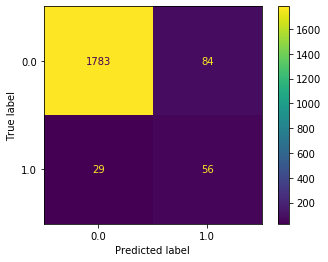

In [54]:
eclf.fit(X_train,y_train)
eclf_pred=eclf.predict(X_test)
plot_confusion_matrix(eclf, X_test, y_test)
class_report=classification_report(y_test,eclf_pred)
print(class_report)
print('Accuracy of ECLF classifier on test set: {:.2f}'
     .format(eclf.score(X_test, y_test)))
print('Accuracy of ECLF cross-validation:',
    cross_val_score(eclf,X_train, y_train, cv=cv).mean())
print('Cross-validation Precission', cross_val_score(eclf, X_train, y_train, cv=cv, scoring = 'precision_macro').mean())
print('Cross-validation  f1', cross_val_score(eclf, X_train, y_train, cv=cv, scoring = 'f1_macro').mean())
print('Cross-validation  Recall', cross_val_score(eclf, X_train, y_train, cv=cv, scoring = 'recall').mean())

### K-vecinos

In [55]:
n_neighbors = list(range(1,30))
p=[1,2]
cv = StratifiedKFold(n_splits=5)
#Convert to dictionary
hyperparameters = dict(n_neighbors=n_neighbors, p=p)
#Create new KNN object
knn = KNeighborsClassifier()
#Use GridSearch
knn_search = GridSearchCV(knn, hyperparameters, cv=cv, scoring="recall", n_jobs=-1)
knn_result= knn_search.fit(X_train,y_train)
# summarize results
print("Best: %f using %s" % (knn_result.best_score_, knn_result.best_params_))
CV_Result = cross_val_score(knn_result, X_train, y_train, cv=cv, scoring="f1_macro")
print(); print(CV_Result)
print(); print(CV_Result.mean())
print(); print(CV_Result.std())

Best: 0.985931 using {'n_neighbors': 3, 'p': 2}

[0.93862296 0.95304925 0.95673729 0.94869498 0.94766369]

0.9489536344653352

0.00609611340223112


<bound method BaseEstimator.get_params of KNeighborsClassifier(n_neighbors=3)>
Accuracy of KNN classifier on test set: 0.90
Accuracy of KNN cross-validation: 0.954308313166637
Cross-validation Precission 0.9561415153908301
Cross-validation  f1 0.9542624715425413
Cross-validation  Recall 0.9859311281063192
              precision    recall  f1-score   support

         0.0       0.99      0.91      0.95      1867
         1.0       0.27      0.74      0.40        85

    accuracy                           0.90      1952
   macro avg       0.63      0.83      0.67      1952
weighted avg       0.96      0.90      0.92      1952



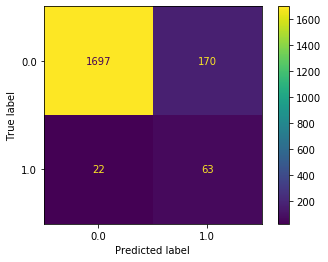

In [56]:
BestKnn=knn_search.best_estimator_
print(BestKnn.get_params)
BestKnn_pred=BestKnn.predict(X_test)
plot_confusion_matrix(BestKnn, X_test, y_test)
class_report=classification_report(y_test,BestKnn_pred)


print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(BestKnn.score(X_test, y_test)))
print('Accuracy of KNN cross-validation:',
    cross_val_score(BestKnn,X_train, y_train, cv=cv).mean())
print('Cross-validation Precission', cross_val_score(BestKnn, X_train, y_train, cv=cv, scoring = 'precision_macro').mean())
print('Cross-validation  f1', cross_val_score(BestKnn, X_train, y_train, cv=cv, scoring = 'f1_macro').mean())
print('Cross-validation  Recall', cross_val_score(BestKnn, X_train, y_train, cv=cv, scoring = 'recall').mean())
print(class_report)

### Logistic

In [57]:
# Gid searching key hyperparametres for logistic regression
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
cv = StratifiedKFold(n_splits=5)
# define models and parameters
log = LogisticRegression(multi_class="multinomial", max_iter=1000, random_state=42)
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
log_search = GridSearchCV(estimator=log, param_grid=grid, n_jobs=-1, cv=cv, scoring='recall')
log_result = log_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (log_result.best_score_, log_result.best_params_))
means = log_result.cv_results_['mean_test_score']
stds = log_result.cv_results_['std_test_score']
params = log_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.917325 using {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
0.916522 (0.003352) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.916522 (0.003352) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
nan (nan) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.916522 (0.003352) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.916522 (0.003352) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
nan (nan) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.916521 (0.003636) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.916521 (0.003636) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
nan (nan) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.916387 (0.004119) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.916387 (0.004119) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
nan (nan) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.917325 (0.004437) with: {'C': 0.01, 'penalty': 'l2', 'solver

              precision    recall  f1-score   support

         0.0       0.99      0.87      0.93      1867
         1.0       0.24      0.89      0.38        85

    accuracy                           0.87      1952
   macro avg       0.62      0.88      0.66      1952
weighted avg       0.96      0.87      0.91      1952

Accuracy of Log classifier on test set: 0.89
Accuracy of Log cross-validation: 0.9170572591665485
Cross-validation Precission 0.9056516057931162
Cross-validation F1 0.9053854746355986
Cross-validation  Recall 0.9170572591665485


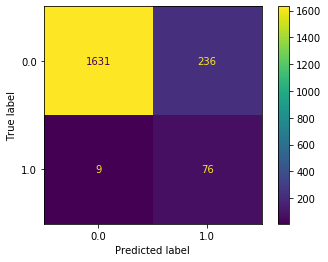

In [58]:
log_pred=log_result.predict(X_test)
plot_confusion_matrix(log_result, X_test, y_test)
class_report=classification_report(y_test,log_pred)
cv = StratifiedKFold(n_splits=5)
print(class_report)
print('Accuracy of Log classifier on test set: {:.2f}'
     .format(log_result.score(X_test, y_test)))
print('Accuracy of Log cross-validation:',
    cross_val_score(log_result,X_train, y_train, cv=cv).mean())
print('Cross-validation Precission', cross_val_score(log_result, X_train, y_train, cv=cv, scoring = 'precision_macro').mean())
print('Cross-validation F1', cross_val_score(log_result, X_train, y_train, cv=cv, scoring = 'f1_macro').mean())
print('Cross-validation  Recall', cross_val_score(log_result, X_train, y_train, cv=cv, scoring = 'recall').mean())

### SVM

In [59]:
from sklearn.svm import SVC
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        SVC(random_state=42, probability=True), tuned_parameters, scoring='%s_macro' % score, cv=5
    )
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    plot_confusion_matrix(clf,X_test, y_test)
    print()


# Tuning hyper-parameters for recall



KeyboardInterrupt: 

# NN

In [4]:
import tensorflow.keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [5]:
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, GlobalMaxPooling1D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

In [6]:
from tensorflow.keras import layers

In [7]:
model = Sequential()
# model.add(Embedding(7805, 128))
model.add(Dense(85, input_dim=85,  activation='relu'))

model.add(Dense(40, activation='tanh'))
model.add(layers.Dropout(0.2))

model.add(Dense(40, activation='relu'))
# model.add(layers.Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [84]:
print(y_train.shape)
print(X_train.shape)

(14926,)
(14926, 85)


In [17]:
model.fit(X_train, y_train, validation_split=0.2, epochs=100,)

Epoch 1/100
374/374 [==============================] - 1s 2ms/step - loss: 0.2669 - accuracy: 0.8953 - val_loss: 0.4249 - val_accuracy: 0.8376
Epoch 2/100
374/374 [==============================] - 0s 1ms/step - loss: 0.2237 - accuracy: 0.9113 - val_loss: 0.2088 - val_accuracy: 0.9317
Epoch 3/100
374/374 [==============================] - 0s 1ms/step - loss: 0.1984 - accuracy: 0.9219 - val_loss: 0.4275 - val_accuracy: 0.8222
Epoch 4/100
374/374 [==============================] - 0s 1ms/step - loss: 0.1697 - accuracy: 0.9379 - val_loss: 0.2632 - val_accuracy: 0.9072
Epoch 5/100
374/374 [==============================] - 0s 1ms/step - loss: 0.1510 - accuracy: 0.9420 - val_loss: 0.1855 - val_accuracy: 0.9411
Epoch 6/100
374/374 [==============================] - 0s 1ms/step - loss: 0.1393 - accuracy: 0.9503 - val_loss: 0.3433 - val_accuracy: 0.8704
Epoch 7/100
374/374 [==============================] - 0s 1ms/step - loss: 0.1291 - accuracy: 0.9534 - val_loss: 0.0672 - val_accuracy: 0.9802

Epoch 58/100
374/374 [==============================] - 0s 1ms/step - loss: 0.0393 - accuracy: 0.9854 - val_loss: 0.0459 - val_accuracy: 0.9856
Epoch 59/100
374/374 [==============================] - 0s 1ms/step - loss: 0.0348 - accuracy: 0.9870 - val_loss: 0.0872 - val_accuracy: 0.9715
Epoch 60/100
374/374 [==============================] - 0s 1ms/step - loss: 0.0304 - accuracy: 0.9889 - val_loss: 0.0343 - val_accuracy: 0.9910
Epoch 61/100
374/374 [==============================] - 0s 1ms/step - loss: 0.0323 - accuracy: 0.9882 - val_loss: 0.0741 - val_accuracy: 0.9759
Epoch 62/100
374/374 [==============================] - 0s 1ms/step - loss: 0.0331 - accuracy: 0.9871 - val_loss: 0.0391 - val_accuracy: 0.9863
Epoch 63/100
374/374 [==============================] - 0s 1ms/step - loss: 0.0320 - accuracy: 0.9894 - val_loss: 0.0890 - val_accuracy: 0.9658
Epoch 64/100
374/374 [==============================] - 0s 1ms/step - loss: 0.0330 - accuracy: 0.9886 - val_loss: 0.0252 - val_accuracy:

In [18]:
nn_pred=model.predict_classes(X_test)
nn_pred

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([[1],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [19]:
print(classification_report(y_test, nn_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97      1867
         1.0       0.41      0.48      0.44        85

    accuracy                           0.95      1952
   macro avg       0.69      0.73      0.71      1952
weighted avg       0.95      0.95      0.95      1952



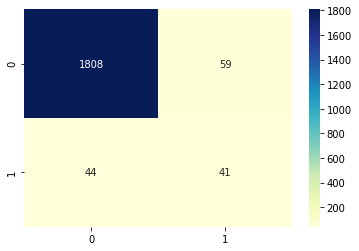

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


sns.heatmap(confusion_matrix(y_test, nn_pred),annot=True,fmt='d',cmap="YlGnBu")

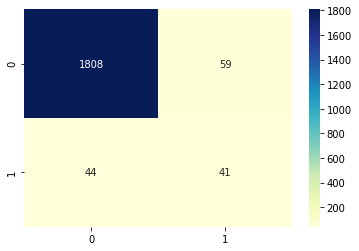

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


sns.heatmap(confusion_matrix(y_test, nn_pred),annot=True,fmt='d',cmap="YlGnBu")